# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [2]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [3]:
env = UnityEnvironment(file_name="../Banana_Linux/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


## Create agent


In [18]:
from dqn_agent import Agent

agent = Agent(state_size=state_size, action_size=action_size, seed=1, use_ddqn=True)


## Define training algorithm

In [7]:
from collections import deque
import torch

def dqn(n_episodes=5, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, checkpointFileName=None):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        checkpointFileName: name of file DQN model weights
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    score_max = 0
    eps = eps_start                    # initialize epsilon
    # Load network parameters
    if checkpointFileName is not None:
        agent.qnetwork_local.load_state_dict(torch.load(checkpointFileName))
        eps = eps_end*10   # Increase starting epsilon in eps-greedy comapred to end epsilon (more curious)  
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}\teps: {:.2f}'.format(i_episode, np.mean(scores_window), eps), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        
        score_mean = np.mean(scores_window)
        if score_mean>=10 and score_mean>(score_max+0.2):
            score_max = score_mean
            print('\nSave  at episode {:d}!\tAverage Score: {:.2f}'.format(i_episode, score_mean))
            checkpointFileName = 'checkpoint_Score_{:.2f}.pth'.format(score_mean)
            torch.save(agent.qnetwork_local.state_dict(), checkpointFileName)
            
    return scores, checkpointFileName

## Run training

Episode 100	Average Score: 0.62	eps: 0.30
Episode 200	Average Score: 5.32	eps: 0.18
Episode 300	Average Score: 9.81	eps: 0.11
Episode 306	Average Score: 10.00	eps: 0.11
Save  at episode 306!	Average Score: 10.00
Episode 317	Average Score: 10.22	eps: 0.10
Save  at episode 317!	Average Score: 10.22
Episode 322	Average Score: 10.43	eps: 0.10
Save  at episode 322!	Average Score: 10.43
Episode 335	Average Score: 10.72	eps: 0.09
Save  at episode 335!	Average Score: 10.72
Episode 344	Average Score: 10.95	eps: 0.09
Save  at episode 344!	Average Score: 10.95
Episode 385	Average Score: 11.15	eps: 0.07
Save  at episode 385!	Average Score: 11.15
Episode 392	Average Score: 11.40	eps: 0.07
Save  at episode 392!	Average Score: 11.40
Episode 399	Average Score: 11.74	eps: 0.07
Save  at episode 399!	Average Score: 11.74
Episode 400	Average Score: 11.77	eps: 0.07
Episode 406	Average Score: 11.99	eps: 0.07
Save  at episode 406!	Average Score: 11.99
Episode 411	Average Score: 12.29	eps: 0.06
Save  at episo

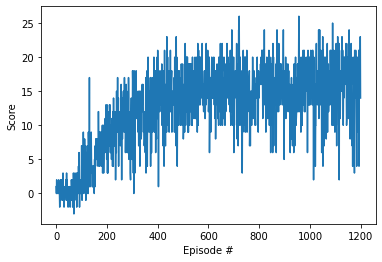

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

# Insert check point file name if train should continue from checkpoint
checkpointFileName = None
#checkpointFileName = 'checkpoint_Score_13.00.pth'
# Run training 
scores, checkpointFileName = dqn(n_episodes=1200, max_t=500, eps_start=0.5, eps_end=0.01, eps_decay=0.995, checkpointFileName=checkpointFileName)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Test trained agent in environment

In [17]:
# Load agent and test agent
# load the weights from file
checkpointFileName = 'checkpoint_Score_16.06.pth'
agent.qnetwork_local.load_state_dict(torch.load(checkpointFileName))

env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = agent.act(state, 0.01)                 # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 22.0


In [21]:
checkpointFileName


'checkpoint_Score_16.06.pth'

## Close environment

In [22]:
env.close()